# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import warnings
import category_encoders as ce
import optuna

from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
pio.renderers.default = 'png'

In [3]:
# Зададим константы для всего проекта
RANDOM_STATE = 42
N_JOBS = -1

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Данные о клиентах банка:
* **age** (возраст);
* **job** (сфера занятости);
* **marital** (семейное положение);
* **education** (уровень образования);
* **default** (имеется ли просроченный кредит);
* **housing** (имеется ли кредит на жильё);
* **loan** (имеется ли кредит на личные нужды);
* **balance** (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
* **contact** (тип контакта с клиентом);
* **month** (месяц, в котором был последний контакт);
* **day** (день, в который был последний контакт);
* **duration** (продолжительность контакта в секундах).

Прочие признаки:
* **campaign** (количество контактов с этим клиентом в течение текущей кампании);
* **pdays** (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* **previous** (количество контактов до текущей кампании)
* **poutcome** (результат прошлой маркетинговой кампании).

Целевая переменная - **deposit** - согласится ли клиент открыть депозит в банке.

### Задание 1. Исследование явных пропущенных значений

In [4]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
df.isna().sum().sort_values(ascending=False).reset_index().rename(columns={'index': 'feature', 0: 'nulls'})

,feature,nulls
0,balance,25
1,age,0
2,day,0
3,poutcome,0
4,previous,0
5,pdays,0
6,campaign,0
7,duration,0
8,month,0
9,contact,0


### Задание 2. Исследование признака `job` на скрытые пропущенные значения.

In [6]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

`unknown` - скрытые пропущенные значения.

### Задание 3. Преобразование `balance` в тип `float`

In [7]:
df['balance'] = df['balance'].apply(
    lambda balance: str(balance).replace('$', '').replace(' ', '').replace(',', '.')
).astype(float)
# Среднее значение преобразованного признака
round(df['balance'].mean(), 3)

1529.129

### Задание 4. Заполнение пропусков в `balance` медианой признака

In [8]:
balance_median = df['balance'].median()
df['balance'].fillna(balance_median, inplace=True)
# Среднее значение признака после заполнения пропусков
round(df['balance'].mean(), 3)

1526.936

### Задание 5. Заполнение пропусков в `job` и `education` модой признаков

In [9]:
job_mode = df['job'].mode()[0]
edu_mode = df['education'].mode()[0]
# Заполням неявные пропуски
df['job'] = df['job'].apply(
    lambda job: job_mode if 'unknown' in job else job
)
df['education'] = df['education'].apply(
    lambda edu: edu_mode if 'unknown' in edu else edu
)
# Узнаем средний баланс клиентов с самой частовстречающейся профессией и самым частовстречающимся образованием
grouped = df.groupby(by=['job', 'education'], as_index=False)['balance'].mean()
mask = (grouped['job'] == job_mode) & (grouped['education'] == edu_mode)
grouped[mask]

,job,education,balance
13,management,secondary,1598.882979


### Задание 6. Удаление выбросов из признака `balance`

In [10]:
def tukey_clean(dataframe:pd.DataFrame, column:str, left=1.5, right=1.5):
    
    """Returns cleaned dataframe using Tukey method

    Args:
        `dataframe` (pd.DataFrame): pandas.DataFrame object
        `column` (str): numeric column in dataframe to clean
        `left` (float, optional): left bound parameter. Defaults to 1.5.
        `right` (float, optional): right bound parameter. Defaults to 1.5.

    Returns:
        `DataFrame`: cleaned dataframe
    """
    
    q_1 = dataframe[column].quantile(0.25)
    q_3 = dataframe[column].quantile(0.75)
    iqr = q_3 - q_1
    left_bound = q_1 - left*iqr
    upper_bound = q_3 + right*iqr
    mask = (dataframe[column] >= left_bound) & (dataframe[column] <= upper_bound)
    return dataframe[mask]

df = tukey_clean(df, 'balance')
df.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1. Сбалансированность классов

In [11]:
df['deposit'].value_counts(normalize=True)

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

Классы сбалансированы, увеличение(уменьшение) какого-либо класса не требуется.

### Задания 2 и 3. Описательные статистики для количественных признаков

In [12]:
df.describe(exclude=object).T

,count,mean,std,min,25%,50%,75%,max
age,10105.0,40.895497,11.734931,18.0,32.0,38.0,48.0,95.0
balance,10105.0,807.653538,994.151966,-2049.0,95.0,445.0,1227.0,4063.0
day,10105.0,15.590302,8.441510,1.0,8.0,15.0,22.0,31.0
duration,10105.0,368.742603,346.651524,2.0,137.0,252.0,490.0,3881.0
campaign,10105.0,2.517170,2.707159,1.0,1.0,2.0,3.0,43.0
pdays,10105.0,51.319644,109.644179,-1.0,-1.0,-1.0,2.0,854.0
previous,10105.0,0.816230,2.243795,0.0,0.0,0.0,1.0,58.0


`age`:
* Наибольший возраст клиента банка - 95 лет
* Медиана от среднего несильно отличается, выбросы не наблюдаются. Возраст подавляющего большинства клиентов - около 40 лет

`balance`:
* Наибольшая задолженность у клиента составляет 2049,00 $
* Наибольший баланс у клиента составляет 4063,00 $
* В основном баланс составляет от ~100$ до ~1200$ (IQR)

`day`:
* Чаще всего банк контактирует с клиентом в 15-й день месяца, то есть в середине месяца.

`duration`:
* У большинства клиентов (IQR) продолжительность разговора с представителем банка составляет от ~130 до ~500 секунд

`campaign`:
* В течение текущей компании с клиентами обычно контактируют не более 3-ёх раз

### Задания 4 и 5. Описательные статистики для категориальных признаков. Визуализация

In [13]:
df.describe(include=object).T

,count,unique,top,freq
job,10105,11,management,2315
marital,10105,3,married,5715
education,10105,3,secondary,5517
default,10105,2,no,9939
housing,10105,2,no,5243
loan,10105,2,no,8712
contact,10105,3,cellular,7283
month,10105,12,may,2617
poutcome,10105,4,unknown,7570
deposit,10105,2,no,5424


`job`:
* Всего уникальных работ у клиентов - 11
* Наиболее встречающаяся - мэнэджмент

`marital`:
* Наибольшее число клиентов женаты или замужем

`education`:
* В основном у клиентов среднее образование

`contact`:
* Чаще всего с клиентами связываются с помощью сотовой связи

`poutcome`:
* У многих клиентов результат прошлой маркетинговой кампании недоступен, скорее всего этот признак неинформативен, т.к. имеет слишком много неизвестных значений

In [14]:
df['month'].value_counts().reset_index()

,index,month
0,may,2617
1,jul,1418
2,aug,1385
3,jun,1104
4,apr,830
5,nov,780
6,feb,709
7,oct,335
8,jan,319
9,sep,278


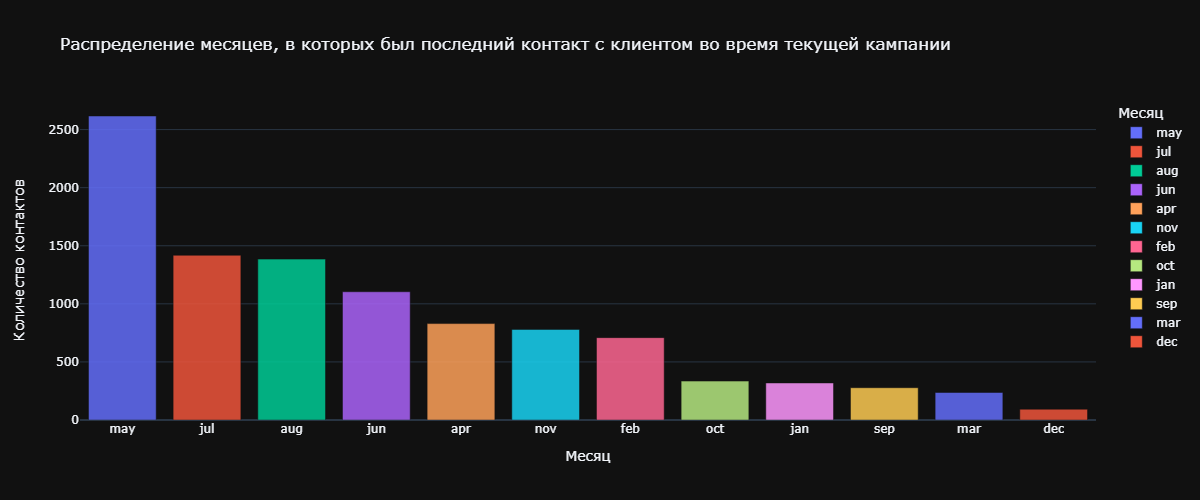

In [15]:
px.bar(
    df['month'].value_counts().reset_index(),
    x='index',
    y='month',
    template='plotly_dark',
    color='index',
    width=1200,
    height=500,
    opacity=0.85,
    title='Распределение месяцев, в которых был последний контакт с клиентом во время текущей кампании',
    labels={'index': 'Месяц', 'month': 'Количество контактов'}
)

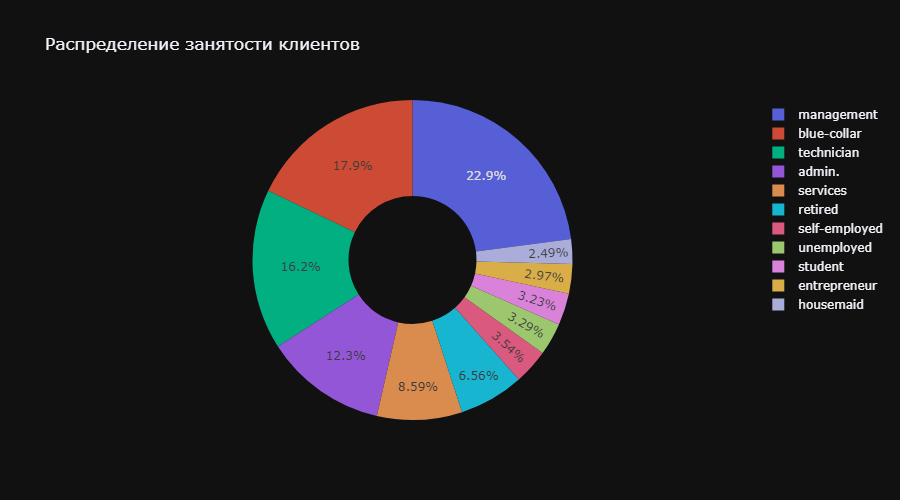

In [16]:
px.pie(
    df,
    names='job',
    template='plotly_dark',
    width=900,
    height=500,
    opacity=0.85,
    title='Распределение занятости клиентов',
    hole=0.4
)

### Задание 6. Визуализация зависимости конверсии от статуса в прошлой кампании

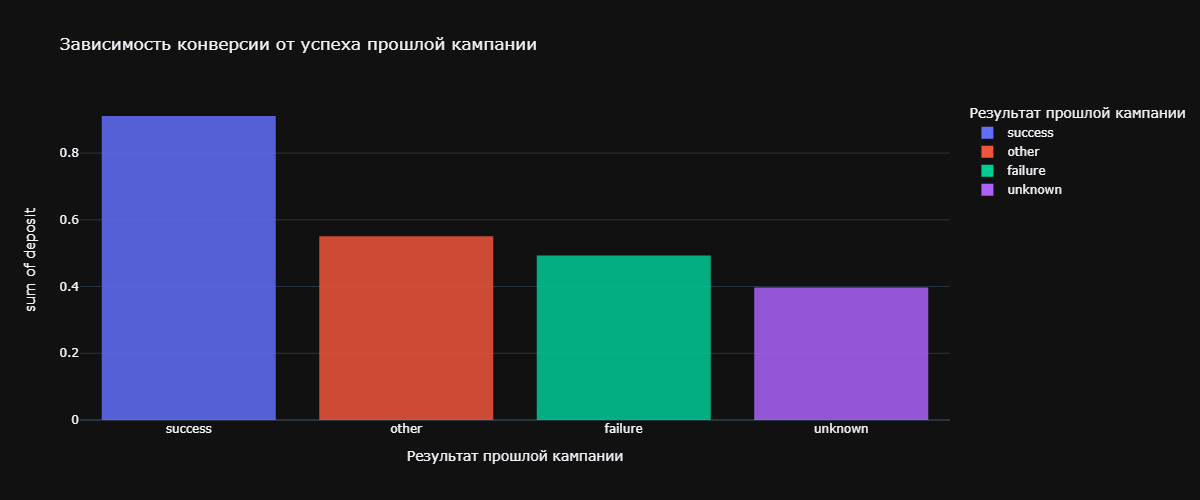

In [17]:
# Создадим дополнительный датафрейм, чтобы было удобнее визуализировать графики
extra_df = df[['poutcome', 'month', 'age', 'marital', 'education', 'job', 'deposit']]
extra_df['deposit'] = extra_df['deposit'].apply(lambda deposit: int('yes' in deposit))
# Считаем конверсию для каждого статуса
conversion = extra_df.groupby(by=['poutcome'], as_index=False)['deposit'].mean().sort_values(by=['deposit'], ascending=False)
# Визуализируем
px.histogram(
    conversion,
    x='poutcome',
    y='deposit',
    color='poutcome',
    template='plotly_dark',
    width=1200,
    height=500,
    title='Зависимость конверсии от успеха прошлой кампании',
    opacity=0.85,
    labels={'poutcome': 'Результат прошлой кампании'}
)

### Задание 7. Визуализация зависимости конверсии от месяца

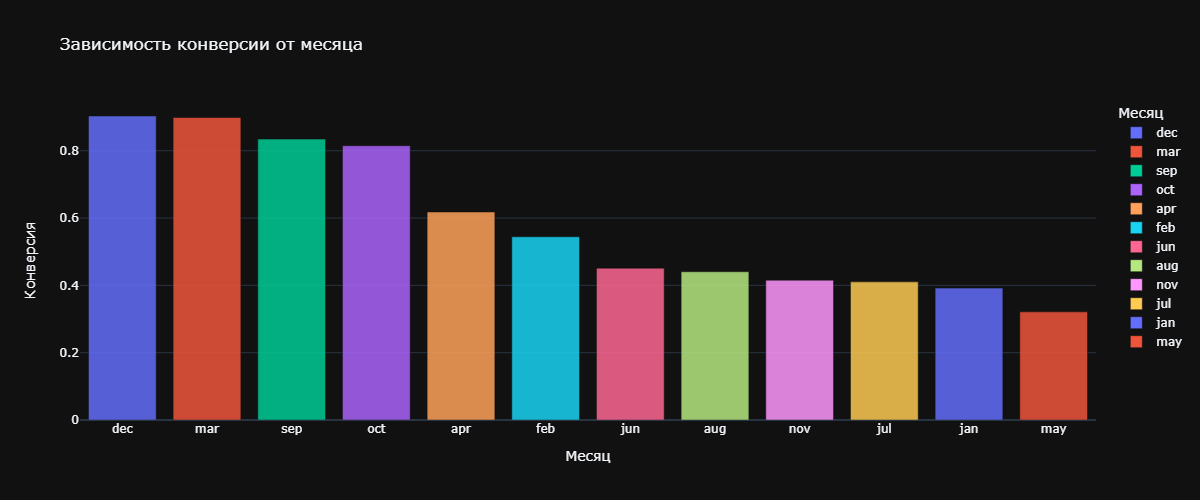

In [18]:
conversion = extra_df.groupby(by=['month'], as_index=False)['deposit'].mean().sort_values(by='deposit', ascending=False)
px.bar(
    conversion,
    x='month',
    y='deposit',
    template='plotly_dark',
    width=1200,
    height=500,
    opacity=0.85,
    color='month',
    title='Зависимость конверсии от месяца',
    labels={'month': 'Месяц', 'deposit': 'Конверсия'}
)

Май является менее подходящим месяцем, чтобы предлагать клиентам открыть депозит.

### Задание 8. Визуализация зависимости конверсии от возрастной категории клиентов

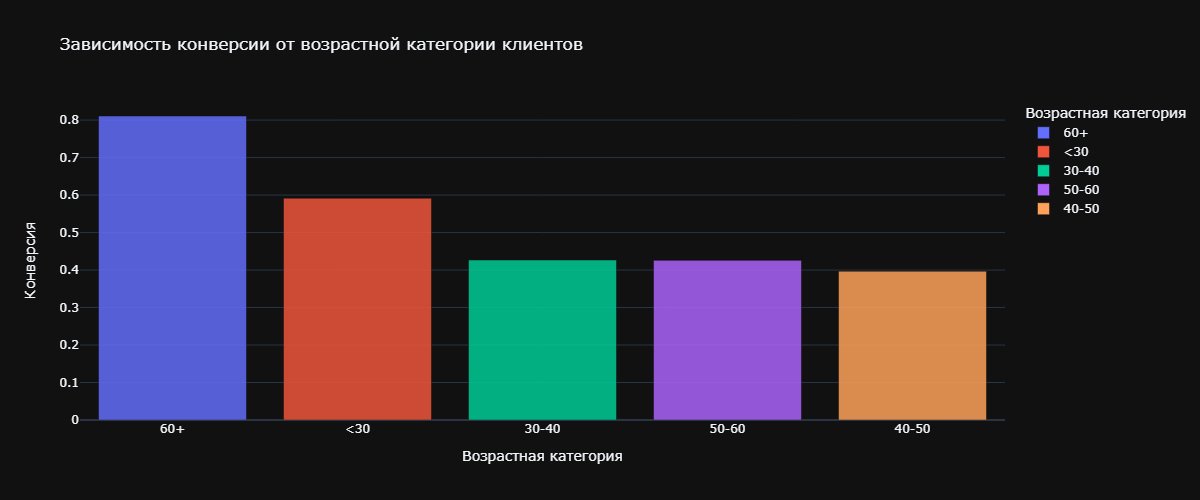

In [19]:
# Функция для кодирования возраста в категориальный признак
def encode_age(age:int):
    age_dict = {
        range(30): '<30',
        range(30, 41): '30-40',
        range(40, 51): '40-50',
        range(50, 61): '50-60',
        range(60, 100): '60+'
    }
    for key in age_dict.keys():
        if age in key:
            return age_dict[key]
# Создадим признак с категорией возраста
extra_df['age_category'] = extra_df['age'].apply(encode_age)
# Группируем
conversion = extra_df.groupby(by=['age_category'], as_index=False)['deposit'].mean().sort_values(by='deposit', ascending=False)
# Строим график
px.bar(
    conversion,
    x='age_category',
    y='deposit',
    color='age_category',
    template='plotly_dark',
    width=1200,
    height=500,
    opacity=0.85,
    title='Зависимость конверсии от возрастной категории клиентов',
    labels={'age_category': 'Возрастная категория', 'deposit': 'Конверсия'}
)

### Задания 9 и 10. Визуализация зависимости конверсии от семейного положения и образования

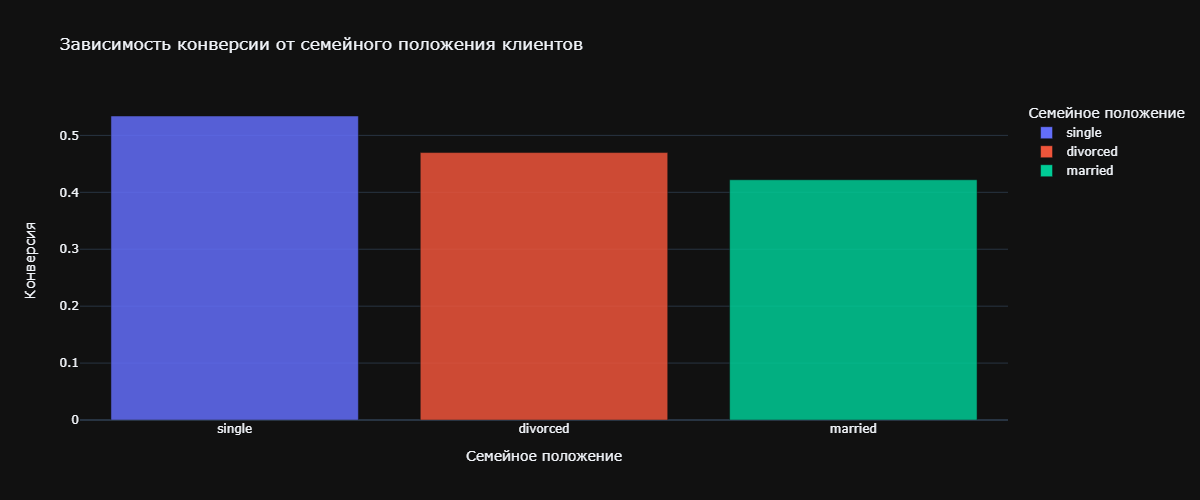

In [20]:
conversion = extra_df.groupby(by=['marital'], as_index=False)['deposit'].mean().sort_values(by='deposit', ascending=False)
px.bar(
    conversion,
    x='marital',
    y='deposit',
    color='marital',
    template='plotly_dark',
    width=1200,
    height=500,
    opacity=0.85,
    title='Зависимость конверсии от семейного положения клиентов',
    labels={'marital': 'Семейное положение', 'deposit': 'Конверсия'}
)

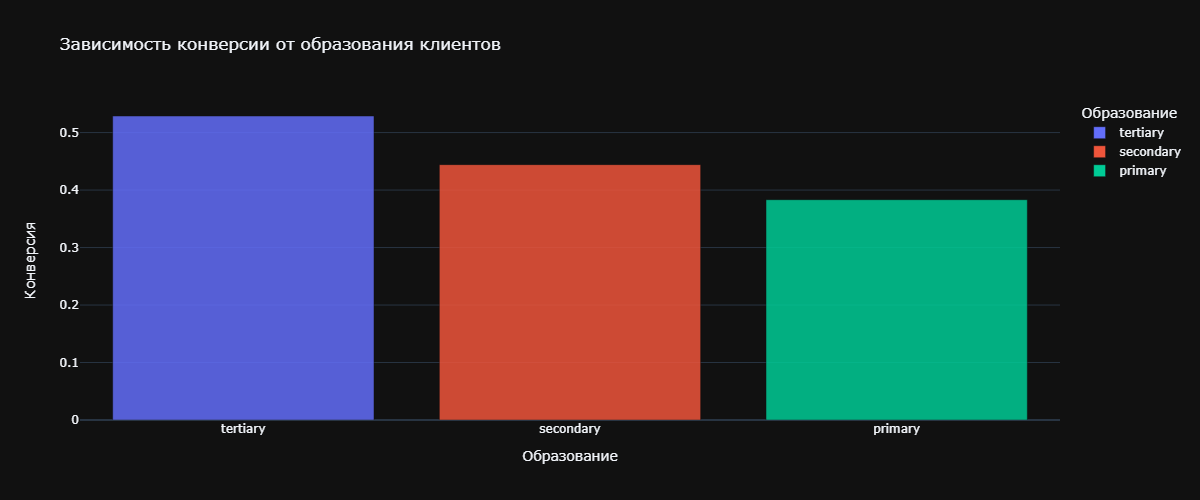

In [21]:
conversion = extra_df.groupby(by=['education'], as_index=False)['deposit'].mean().sort_values(by='deposit', ascending=False)
px.bar(
    conversion,
    x='education',
    y='deposit',
    color='education',
    template='plotly_dark',
    width=1200,
    height=500,
    opacity=0.85,
    title='Зависимость конверсии от образования клиентов',
    labels={'education': 'Образование', 'deposit': 'Конверсия'}
)

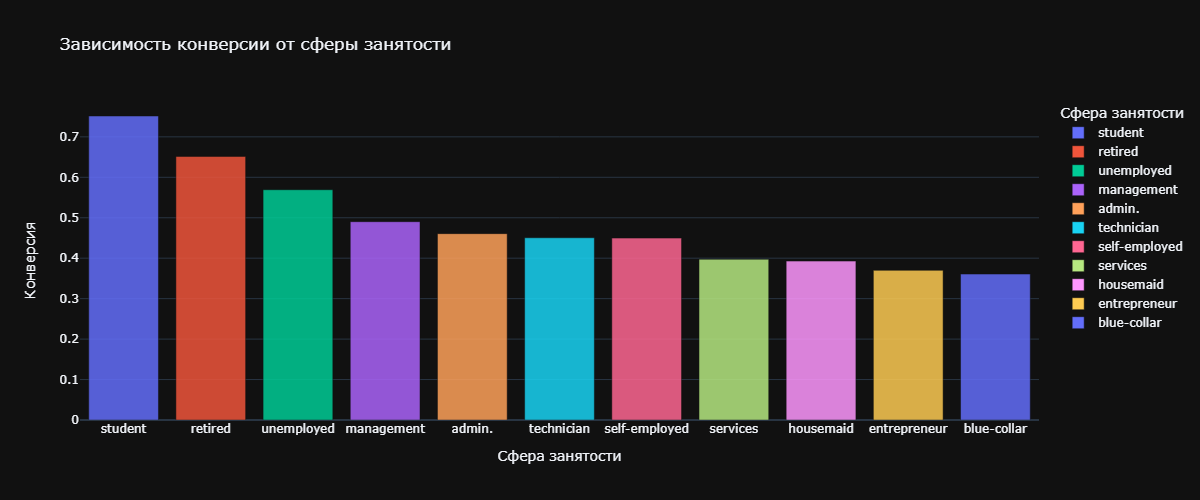

In [22]:
conversion = extra_df.groupby(by=['job'], as_index=False)['deposit'].mean().sort_values(by='deposit', ascending=False)
px.bar(
    conversion,
    x='job',
    y='deposit',
    color='job',
    template='plotly_dark',
    width=1200,
    height=500,
    opacity=0.85,
    title='Зависимость конверсии от сферы занятости',
    labels={'job': 'Сфера занятости', 'deposit': 'Конверсия'}
)

### Задание 11

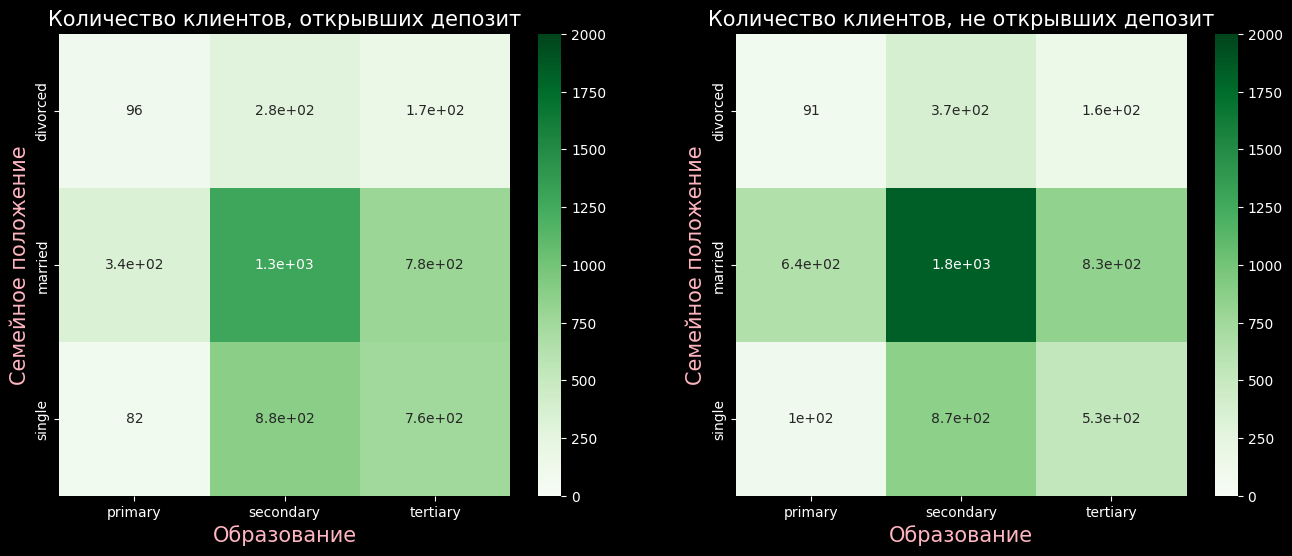

In [23]:
# Разделим датафрейм на клиентов, открывших и не открывших депозит
positive_grouped = extra_df[extra_df['deposit'] == 1]
negative_grouped = extra_df[extra_df['deposit'] == 0]
# Сделаем сводные таблицы для разделенных клиентов по признакам образования и семейного положения
positive_pivot = positive_grouped.pivot_table(
    values='deposit',
    aggfunc='count',
    index='marital',
    columns='education'
)
negative_pivot = negative_grouped.pivot_table(
    values='deposit',
    aggfunc='count',
    index='marital',
    columns='education'
)
# Визуализируем 2 тепловые карты для каждой категории
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(positive_pivot, annot=True, ax=axes[0], vmax=2000, vmin=0, cmap='Greens').set_title('Количество клиентов, открывших депозит', fontsize=15)
sns.heatmap(negative_pivot, annot=True, ax=axes[1], vmax=2000, vmin=0, cmap='Greens').set_title('Количество клиентов, не открывших депозит', fontsize=15)
axes[0].set_ylabel('Семейное положение', fontsize=15, color='lightpink')
axes[0].set_xlabel('Образование', fontsize=15, color='lightpink')
axes[1].set_ylabel('Семейное положение', fontsize=15, color='lightpink')
axes[1].set_xlabel('Образование', fontsize=15, color='lightpink');

Наиболее популярные группы для открывших и не открывших депозит клиентов не отличаются. Вероятно, это связано с тем, что в данных преобладают клиенты следующего пересечения категорий - `married & secondary`

## Часть 3: преобразование данных

### Задание 1. Кодирование признаков `education` и `age_cat`

In [24]:
le = LabelEncoder()
encoded_df = df.copy()
encoded_df['education'] = le.fit_transform(df['education'])
encoded_df['age_cat'] = le.fit_transform(extra_df['age_category'])

### Задания 2 и 3. Кодирование бинарных признаков

In [25]:
binary_cols = ['deposit', 'housing', 'loan', 'default']
for col in binary_cols:
    encoded_df[col] = df[col].apply(lambda x: int('yes' in x))

### Задание 4. Кодирование категориальный признаков в dummy-признаки

In [26]:
dummy_cols_names = ['job', 'marital', 'contact', 'month', 'poutcome']
oh_encoder = ce.OneHotEncoder(use_cat_names=True)
dummy_cols = oh_encoder.fit_transform(encoded_df[dummy_cols_names])

encoded_df = pd.concat([encoded_df, dummy_cols], axis=1)
print('Shape with dummy cols(with original cols):', encoded_df.shape)
encoded_df.drop(columns=dummy_cols_names, inplace=True)
print('Shape with dummy cols(without original cols):', encoded_df.shape)

Shape with dummy cols(with original cols): (10105, 51)
Shape with dummy cols(without original cols): (10105, 46)


### Задания 5 и 6. Визуализация матрицы корреляции, исследование признаков на мультиколлинеарность

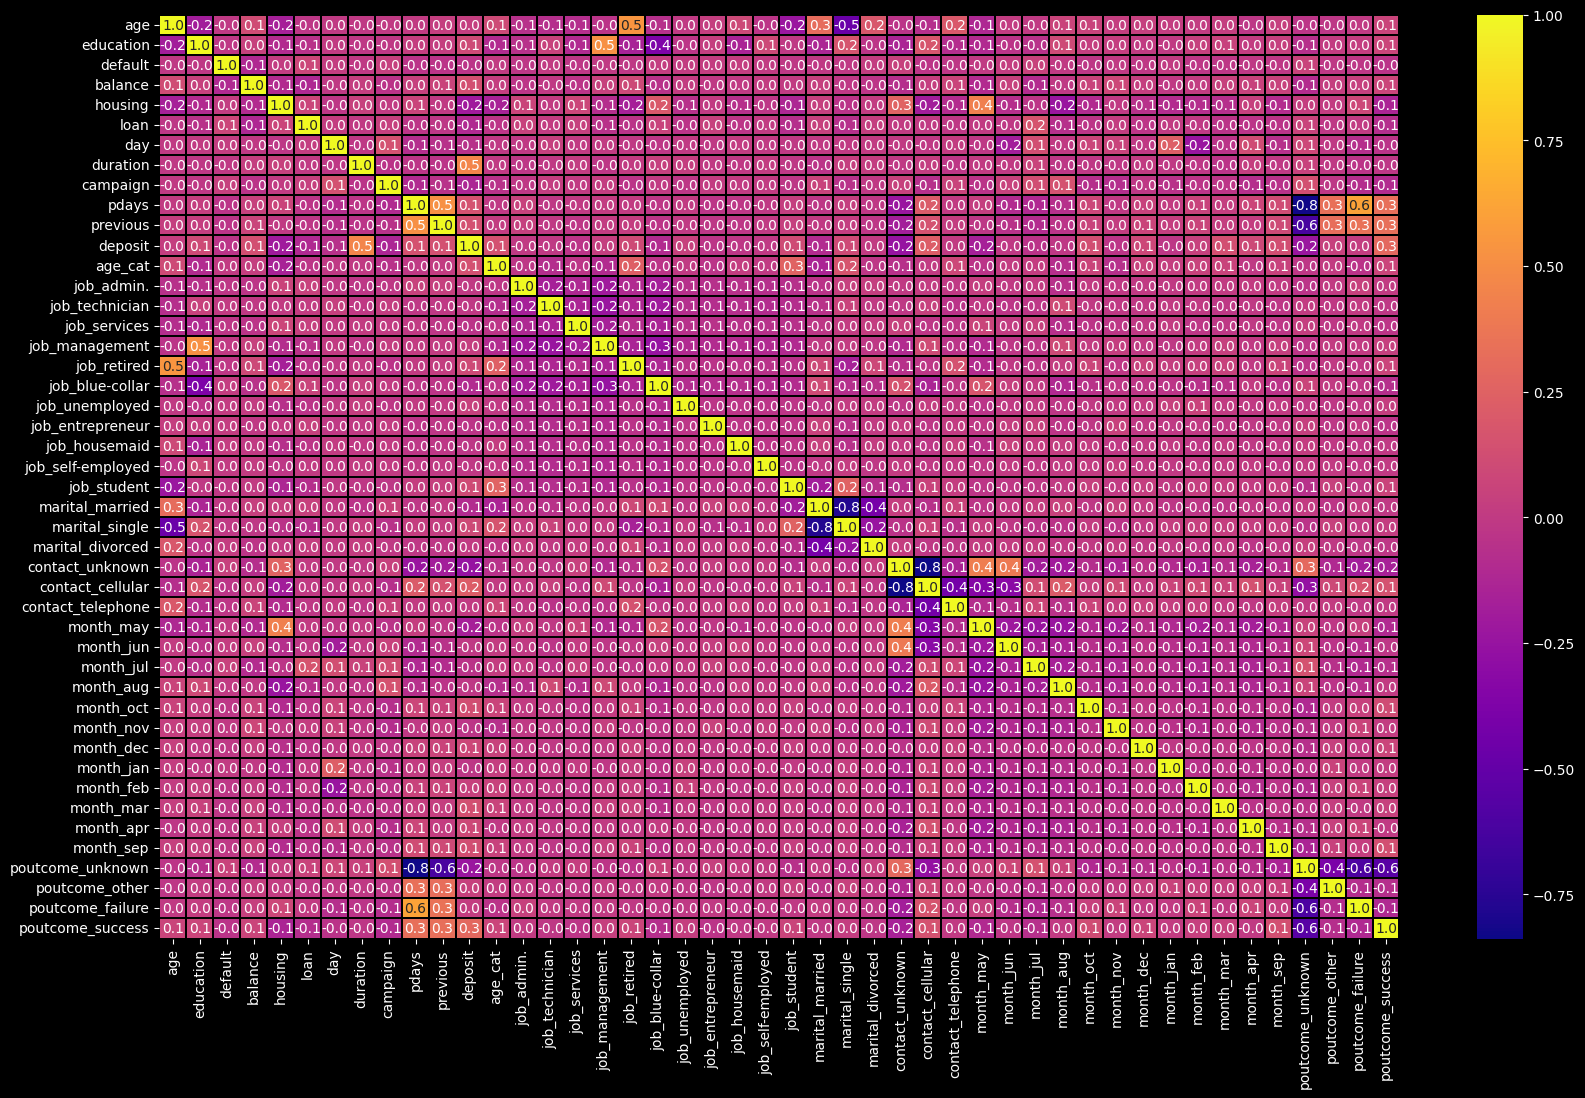

In [27]:
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(encoded_df.corr(), ax=ax, annot=True, cmap='plasma', fmt='.1f', linewidths=0.05, linecolor='black');

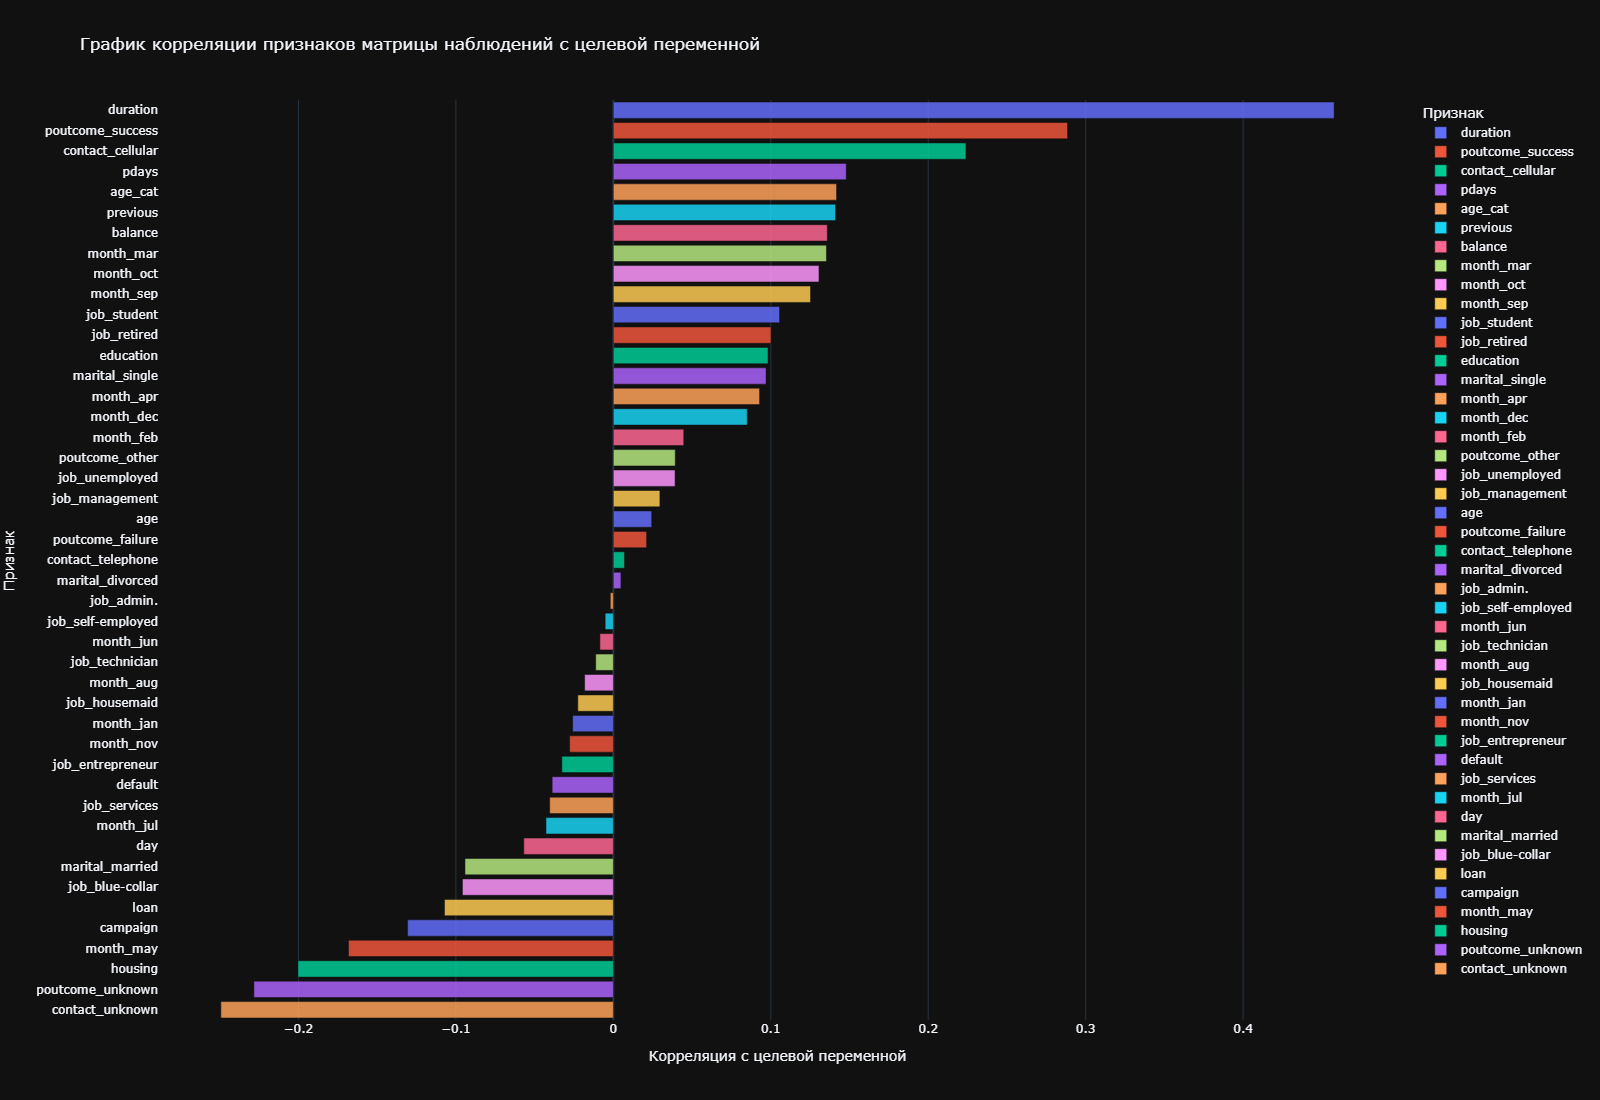

In [28]:
bar_plot = encoded_df.corr()[['deposit']].sort_values(by='deposit', ascending=False).drop(index='deposit').reset_index()
px.bar(
    bar_plot,
    y='index',
    x='deposit',
    template='plotly_dark',
    opacity=0.85,
    labels={'index': 'Признак', 'deposit': 'Корреляция с целевой переменной'},
    color='index',
    width=1600,
    height=1100,
    title='График корреляции признаков матрицы наблюдений с целевой переменной'
)

### Задания 7 и 8. Разделение выборки на матрицу наблюдений и вектор правильных ответов

In [29]:
X = encoded_df.drop(['deposit'], axis=1)
y = encoded_df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6770, 45) (3335, 45) (6770,) (3335,)


### Задание 9. Отбор наиболее важных признаков с помощью `SelectKBest`

In [30]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
best_features = selector.get_feature_names_out()

X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]

### Задание 10. Нормализация с помощью `MinMaxScaler`

In [31]:
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train_selected)

X_train_scaled = mm_scaler.transform(X_train_selected)
X_test_scaled = mm_scaler.transform(X_test_selected)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1. Построение логистической регрессии

In [32]:
logreg = linear_model.LogisticRegression(
    solver='sag',
    max_iter=1000,
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE
)
# Обучаем модель
logreg.fit(X_train_scaled, y_train)
y_test_pred = logreg.predict(X_test_scaled)
# Считаем метрики для тестовой выборки
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4. Построение решающих дереьвев

In [33]:
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=RANDOM_STATE
)
# Обучаем модель
dt_clf.fit(X_train_scaled, y_train)
y_train_pred = dt_clf.predict(X_train_scaled)
y_test_pred = dt_clf.predict(X_test_scaled)
# Считаем метрики для тестовой выборки
print('Train report:\n', metrics.classification_report(y_train, y_train_pred))
print('======'*9)
print('Test report:\n', metrics.classification_report(y_test, y_test_pred))

Train report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Test report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



### Задание 5. Поиск наилучших параметров с помощью GridSearchCV

In [34]:
# Модель
estimator = tree.DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    criterion='entropy'
)
# Сетка параметров
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}
gridsearch = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    n_jobs=N_JOBS,
    cv=5,
    verbose=True
)
%time gridsearch.fit(X_train_scaled, y_train)
y_train_pred = gridsearch.predict(X_train_scaled)
y_test_pred = gridsearch.predict(X_test_scaled)
# Считаем метрики
print('Train report:\n', metrics.classification_report(y_train, y_train_pred))
print('======'*9)
print('Test report:\n', metrics.classification_report(y_test, y_test_pred))
print('GridSearchCV best params:', gridsearch.best_params_)
print('F1-score for best estimator:', metrics.f1_score(y_test, y_test_pred).round(2))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 391 ms
Wall time: 3.53 s
Train report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      3634
           1       0.82      0.83      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.83      0.84      0.83      6770
weighted avg       0.84      0.84      0.84      6770

Test report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.80      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

GridSearchCV best params: {'max_depth': 7, 'min_samples_split': 10}
F1-score for best estimator: 0.81


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1. Построение случайного леса

In [35]:
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)
rf_clf.fit(X_train_scaled, y_train)
y_test_pred = rf_clf.predict(X_test_scaled)
print('Test report:\n', metrics.classification_report(y_test, y_test_pred))

Test report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задания 2 и 3. Построение градиентного бустинга и сравнение результатов со случайным лесом

In [36]:
gb_clf = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=RANDOM_STATE
)
gb_clf.fit(X_train_scaled, y_train)
y_test_pred = gb_clf.predict(X_test_scaled)
print('Test report:\n', metrics.classification_report(y_test, y_test_pred))

Test report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.83      3335



Разница не наблюдается, обе модели показывают одинаковый результат на тестовой выборке.

### Задание 4. Использование стекинга. В качестве базовых моделей - написанные ранее. В качестве финальной модели - логистическа регрессия

In [37]:
stacking = ensemble.StackingClassifier(
    estimators=[
        ('LogisticRegression', logreg), 
        ('DecisionTreeClassifier', gridsearch.best_estimator_),
        ('RandomForestClassifier', rf_clf), 
        ('GradientBoostingClassifier', gb_clf)
    ],
    final_estimator=logreg,
    n_jobs=N_JOBS
)
stacking.fit(X_train_scaled, y_train)
y_test_pred = stacking.predict(X_test_scaled)
print('Test report:\n', metrics.classification_report(y_test, y_test_pred))

Test report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5. Оценка важности признаков с точки зрения градиентного бустинга

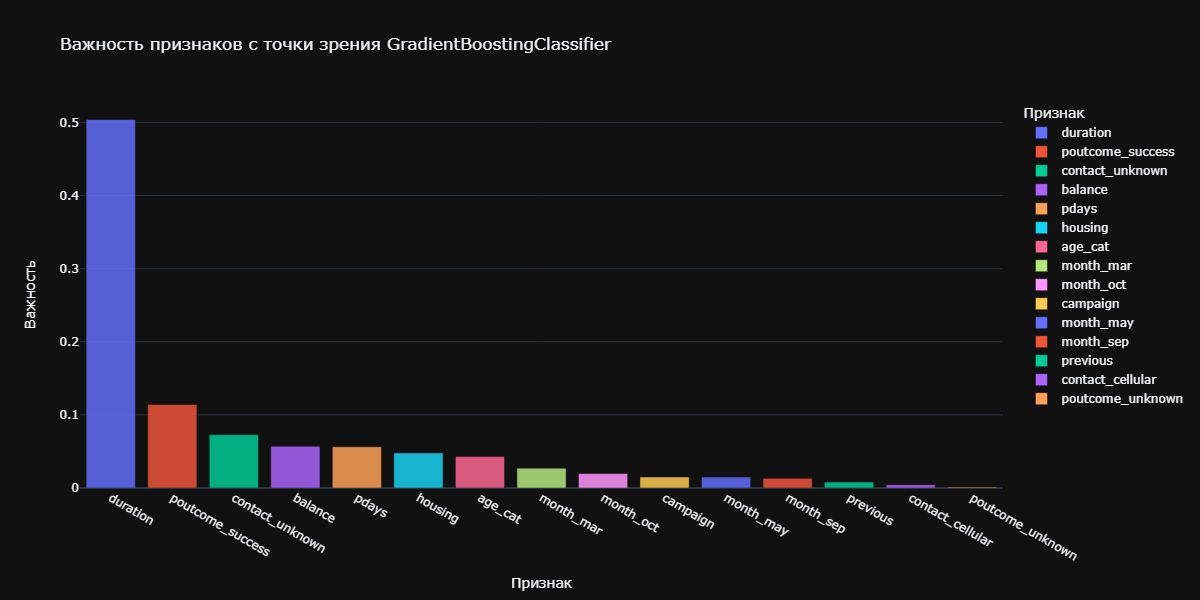

In [38]:
feature_importances = pd.DataFrame(gb_clf.feature_importances_, index=best_features).sort_values(by=0, ascending=False).rename(columns={0: 'importance'}).reset_index()
px.bar(
    feature_importances,
    x='index',
    y='importance',
    template='plotly_dark',
    width=1200,
    height=600,
    opacity=0.85,
    color='index',
    title='Важность признаков с точки зрения GradientBoostingClassifier',
    labels={'index': 'Признак', 'importance': 'Важность'}
)

### Задания 6,7,8. Поиск параметров с помощью `Optuna`

In [39]:
def optuna_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200, 1),
        'max_depth': trial.suggest_int('max_depth', 10, 30, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10, 1),
        'random_state': RANDOM_STATE,
        'n_jobs': N_JOBS
    }
    model = ensemble.RandomForestClassifier(**params)
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
    return score

study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_rf, n_jobs=N_JOBS, n_trials=20)
print('Optuna best params:', study.best_params)

[I 2023-03-26 18:38:25,552] A new study created in memory with name: RandomForestClassifier
[I 2023-03-26 18:38:31,704] Trial 11 finished with value: 0.8486087093224336 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_leaf': 7}. Best is trial 11 with value: 0.8486087093224336.
[I 2023-03-26 18:38:31,756] Trial 7 finished with value: 0.8483992467043315 and parameters: {'n_estimators': 111, 'max_depth': 30, 'min_samples_leaf': 10}. Best is trial 11 with value: 0.8486087093224336.
[I 2023-03-26 18:38:31,759] Trial 1 finished with value: 0.8715048696198554 and parameters: {'n_estimators': 107, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8715048696198554.
[I 2023-03-26 18:38:31,761] Trial 3 finished with value: 0.9262926292629262 and parameters: {'n_estimators': 110, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9262926292629262.
[I 2023-03-26 18:38:31,766] Trial 2 finished with value: 0.9254716981132076 and parameters: 

Optuna best params: {'n_estimators': 110, 'max_depth': 28, 'min_samples_leaf': 2}


In [40]:
rf_clf = ensemble.RandomForestClassifier(
    **study.best_params,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)
rf_clf.fit(X_train_scaled, y_train)
y_test_pred = rf_clf.predict(X_test_scaled)
print('Test report:\n', metrics.classification_report(y_test, y_test_pred))

Test report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



## Вывод
|Модель|$F_1-score$|
|------|-----------|
|<font color=lightpink>LogisticRegression</font>|<font color=lightpink>0.78</font>|
|DecisionTreeClassifier|0.81|
|GradientBoostingClassifier|0.81|
|<font color=lightgreen>RandomForestClassifier</font>|<font color=lightgreen>0.82</font>|

`RandomForestClassifier` в совокупности с  `Optuna` показал наилучший результат для предсказания задачи классификации, в которой необходимо определить, согласится ли клиент на депозит.